# Deep Learnign Final Project: Image Classification with PyTorch

## Overview
In this project, we design, train, and analyze Convolutional Neural Networks (CNNs) to classify images of bathroom environments (Toilet, No-Toilet, Not-Bathroom). This work builds upon a previous study conducted using the **fastai** library.

## Key Experiments
1.  **Training from Scratch:** We will design custom CNN architectures (Shallow vs. Deep) and analyze the impact of Batch Normalization and Regularization.
2.  **Transfer Learning (Feature Extraction):** We will pretrain a model on a proxy dataset (CIFAR-10) and transfer the weights to our specific domain.
3.  **Fine-Tuning ResNet50:** We will adapt an industry-standard ResNet50 model to push the limits of accuracy on our dataset.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

# 1. Configuration
DATA_PATH = 'data'  # root folder containing the 3 class folders
BATCH_SIZE = 32
IMG_SIZE = 300     
VALID_SPLIT = 0.2   # 20% for validation
SEED = 42           # for reproducibility

# Normalization Constants 
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define Transforms
# We use Resize((h, w)) which squishes images by default, like FastAI's 'squish'
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Standard normalization for stable training
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# 3. Load Data & Split
try:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=data_transforms)
    
    # Calculate split sizes
    val_size = int(len(full_dataset) * VALID_SPLIT)
    train_size = len(full_dataset) - val_size
    
    # Create the split using a generator for reproducibility
    generator = torch.Generator().manual_seed(SEED)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    class_names = full_dataset.classes
    print(f"Data loaded successfully!")
    print(f"Classes: {class_names}")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    
except FileNotFoundError:
    print(f"Error: Could not find directory '{DATA_PATH}'. Check your path.")

Using device: cpu
Data loaded successfully!
Classes: ['no-toilet', 'not-bathroom', 'toilet']
Training images: 268
Validation images: 66


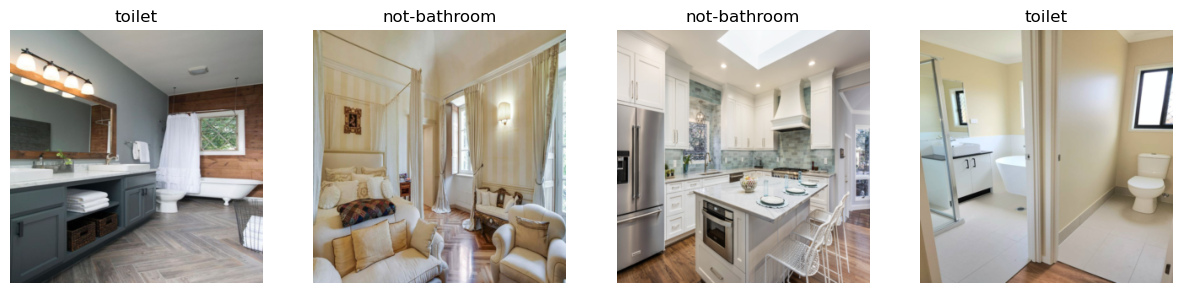

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Undo normalization for display
    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch (showing first 4 images)
plt.figure(figsize=(15, 5))
for i in range(min(4, len(inputs))):
    plt.subplot(1, 4, i+1)
    imshow(inputs[i], title=class_names[classes[i]])
plt.show()

## The training function

In [7]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Deep copy the model if it's the best one so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### We will compare 2 models:
Lets explort two distinct architectures to investigate the impact of depth on feature extraction capabilities:

1.The Shallow Model (SimpleCNN): Consists of only two convolutional blocks. With fewer layersit focuses primarily on low-level features like edges, color blobs, and simple textures. It lacks the hierarchical capacity to assemble these simple features into complex object parts (like a toilet bowl shape).

In [9]:
import torch.nn.functional as F

# 1. The Shallow Network (2 Conv Layers)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        # Block 1: 3 input channels (RGB) -> 16 output filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: 16 -> 32 filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Adaptive Pool: Forces output to 1x1 per channel (size becomes 32 x 1 x 1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification Layer: 32 inputs -> 3 outputs (classes)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.flatten(1) # Flatten dimensions for linear layer
        x = self.fc(x)
        return x

2.The Deep Model (DeepCNN): Utilizes four convolutional blocks with increased filter counts (32 -> 256). This depth allows for hierarchical feature learning: early layers detect edges, middle layers detect shapes (curves, corners), and deeper layers detect semantic objects (bathroom fixtures).

In [10]:
# 2. The Deep Network (4 Conv Layers + More Filters)
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Classification Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.gap(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [11]:
# --- Experiment 1: Shallow CNN ---
print("Training Shallow CNN...")
model_shallow = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
# Adam is usually faster to converge than SGD for simple tasks
optimizer_shallow = optim.Adam(model_shallow.parameters(), lr=0.001)

model_shallow, hist_shallow = train_model(model_shallow, criterion, optimizer_shallow, num_epochs=10)


# --- Experiment 2: Deep CNN ---
print("\nTraining Deep CNN...")
model_deep = DeepCNN(num_classes=len(class_names)).to(device)
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001)

model_deep, hist_deep = train_model(model_deep, criterion, optimizer_deep, num_epochs=10)

Training Shallow CNN...
Epoch 1/10
----------
train Loss: 1.1068 Acc: 0.3284
val Loss: 1.0932 Acc: 0.4091
Epoch 2/10
----------
train Loss: 1.0870 Acc: 0.3918
val Loss: 1.0971 Acc: 0.3485
Epoch 3/10
----------
train Loss: 1.0828 Acc: 0.3955
val Loss: 1.0966 Acc: 0.4394
Epoch 4/10
----------
train Loss: 1.0749 Acc: 0.4590
val Loss: 1.0956 Acc: 0.4394
Epoch 5/10
----------
train Loss: 1.0695 Acc: 0.4627
val Loss: 1.1012 Acc: 0.4394
Epoch 6/10
----------
train Loss: 1.0637 Acc: 0.4664
val Loss: 1.0989 Acc: 0.4242
Epoch 7/10
----------
train Loss: 1.0597 Acc: 0.4590
val Loss: 1.0932 Acc: 0.4394
Epoch 8/10
----------
train Loss: 1.0497 Acc: 0.4627
val Loss: 1.1000 Acc: 0.4848
Epoch 9/10
----------
train Loss: 1.0424 Acc: 0.4664
val Loss: 1.1010 Acc: 0.4848
Epoch 10/10
----------
train Loss: 1.0340 Acc: 0.5000
val Loss: 1.0993 Acc: 0.4394

Training complete in 4m 20s
Best Val Acc: 0.4848

Training Deep CNN...
Epoch 1/10
----------
train Loss: 1.0815 Acc: 0.4216
val Loss: 1.0927 Acc: 0.4394
E

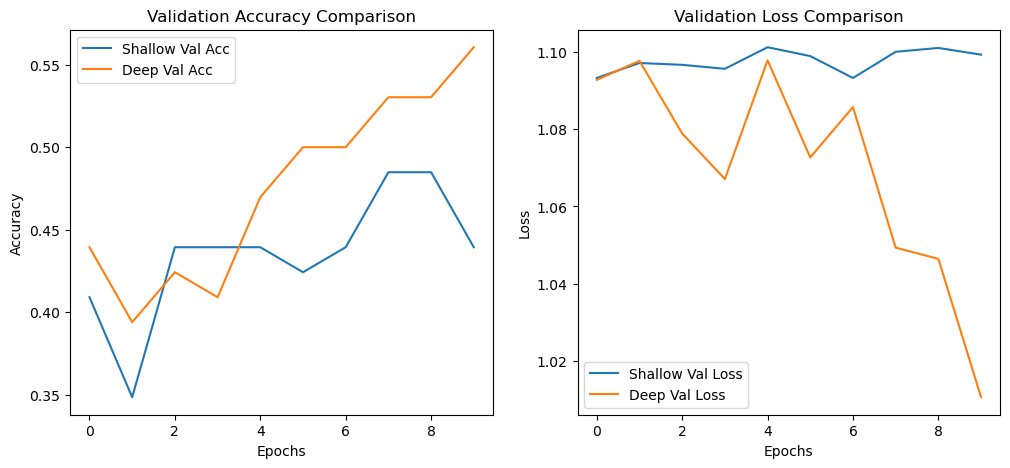

In [32]:
def plot_comparison(hist1, name1, hist2, name2):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist1['val_acc'], label=f'{name1} Val Acc')
    plt.plot(hist2['val_acc'], label=f'{name2} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist1['val_loss'], label=f'{name1} Val Loss')
    plt.plot(hist2['val_loss'], label=f'{name2} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_comparison(hist_shallow, "Shallow", hist_deep, "Deep")

As expected the DeepCNN architecture performed better, however we can see that accuracy is still very bad in both, esspecially let's experiment with hyperparameters and optimization algorithms to see how it impacts accuracy. 
First I increased the amount of epochs as I saw the iprovements in were still sometimes significants in the later epochs. 

In [34]:
experiments = {}  # Dictionary to store all results
NUM_EPOCHS = 12

print("STARTING EXPERIMENT")
print("="*30)

# ==========================================
# ROUND 1: SimpleCNN (The Shallow Model)
# ==========================================

# 1. SimpleCNN + Adam
print("\nRUN 1: SimpleCNN + Adam (lr=0.001)")
model = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
_, experiments['Shallow_Adam'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

# 2. SimpleCNN + SGD
print("\nRUN 2: SimpleCNN + SGD (lr=0.01, momentum=0.9)")
model = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
_, experiments['Shallow_SGD'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)


# ==========================================
# ROUND 2: DeepCNN (The Deep Model)
# ==========================================

# 3. DeepCNN + Adam
print("\nRUN 3: DeepCNN + Adam (lr=0.001)")
model = DeepCNN(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
_, experiments['Deep_Adam'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

# 4. DeepCNN + SGD
print("\nRUN 4: DeepCNN + SGD (lr=0.01, momentum=0.9)")
model = DeepCNN(num_classes=len(class_names)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
_, experiments['Deep_SGD'] = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

print("\nAll Experiments Complete!")

STARTING EXPERIMENT

RUN 1: SimpleCNN + Adam (lr=0.001)
Epoch 1/12
----------
train Loss: 1.1106 Acc: 0.3470
val Loss: 1.1070 Acc: 0.2879
Epoch 2/12
----------
train Loss: 1.0904 Acc: 0.3918
val Loss: 1.0945 Acc: 0.4545
Epoch 3/12
----------
train Loss: 1.0785 Acc: 0.4664
val Loss: 1.0980 Acc: 0.4091
Epoch 4/12
----------
train Loss: 1.0678 Acc: 0.4590
val Loss: 1.0963 Acc: 0.4091
Epoch 5/12
----------
train Loss: 1.0630 Acc: 0.4515
val Loss: 1.1015 Acc: 0.4242
Epoch 6/12
----------
train Loss: 1.0583 Acc: 0.4440
val Loss: 1.1049 Acc: 0.3939
Epoch 7/12
----------
train Loss: 1.0509 Acc: 0.4739
val Loss: 1.1183 Acc: 0.4091
Epoch 8/12
----------
train Loss: 1.0464 Acc: 0.4590
val Loss: 1.1162 Acc: 0.3939
Epoch 9/12
----------
train Loss: 1.0408 Acc: 0.4291
val Loss: 1.1157 Acc: 0.3939
Epoch 10/12
----------
train Loss: 1.0392 Acc: 0.4701
val Loss: 1.1233 Acc: 0.4091
Epoch 11/12
----------
train Loss: 1.0312 Acc: 0.4776
val Loss: 1.1304 Acc: 0.3788
Epoch 12/12
----------
train Loss: 1.028

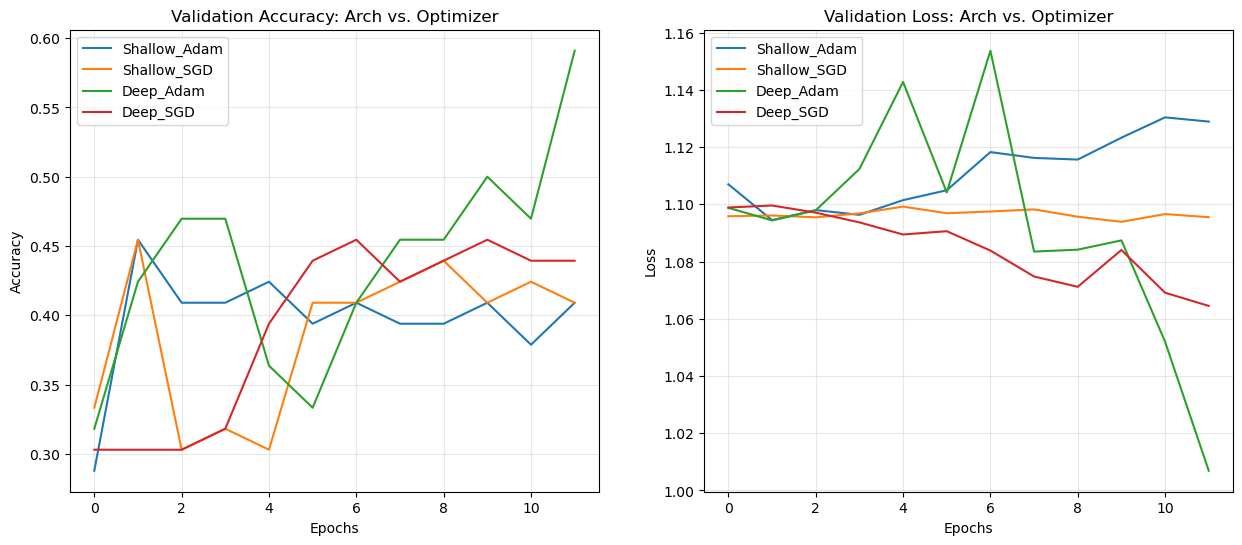

In [37]:
plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
for name, hist in experiments.items():
    plt.plot(hist['val_acc'], label=name)
plt.title('Validation Accuracy: Arch vs. Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
for name, hist in experiments.items():
    plt.plot(hist['val_loss'], label=name)
plt.title('Validation Loss: Arch vs. Optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Analysis: Architecture & Optimization Results
Experimental Results: Deep Architecture with Adam Optimization

Our comparative analysis identifies the Deep CNN trained with Adam as the clear top performer, achieving a peak validation accuracy of approximately 60%, significantly outperforming the Shallow architecture counterparts which stagnated near 40%. This performance gap confirms that the problem complexity requires a deeper hierarchical structure to effectively extract semantic features (such as "toilet" vs. "sink") rather than just low-level edges.

regarding optimization, Adam demonstrated superior convergence speed compared to SGD with Momentum. While SGD provided a smoother, more stable loss reduction, it failed to reach a competitive minimum within the epoch limit (ending ~44%). In contrast, Adam's adaptive learning rates allowed the model to rapidly navigate the loss landscape.

Critical Observation: However, the validation loss curve for the Deep/Adam model (Green line) exhibits significant volatility and "jaggedness." This instability indicates that while the model is learning rapidly, it is oscillating in the loss landscape and likely overfitting to specific batches. This specific finding provides the motivation for our next experimental phase: introducing Batch Normalization to stabilize training and Regularization to improve generalization.

### Batch normalization

In [22]:
class DeepCNN_BN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN_BN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # <--- Added Batch Norm
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # <--- Added Batch Norm
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # <--- Added Batch Norm
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256) # <--- Added Batch Norm
        
        # Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Order: Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.gap(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x


Training Deep CNN with Batch Norm...
Epoch 1/10
----------
train Loss: 0.9562 Acc: 0.5000
val Loss: 1.2547 Acc: 0.4091
Epoch 2/10
----------
train Loss: 0.8909 Acc: 0.5634
val Loss: 1.3904 Acc: 0.3485
Epoch 3/10
----------
train Loss: 0.8365 Acc: 0.5858
val Loss: 1.4234 Acc: 0.4091
Epoch 4/10
----------
train Loss: 0.8530 Acc: 0.6082
val Loss: 1.0868 Acc: 0.4394
Epoch 5/10
----------
train Loss: 0.8113 Acc: 0.6343
val Loss: 1.0025 Acc: 0.4697
Epoch 6/10
----------
train Loss: 0.8104 Acc: 0.6381
val Loss: 0.9671 Acc: 0.5152
Epoch 7/10
----------
train Loss: 0.7790 Acc: 0.6418
val Loss: 1.0378 Acc: 0.5455
Epoch 8/10
----------
train Loss: 0.7758 Acc: 0.6604
val Loss: 0.9255 Acc: 0.6212
Epoch 9/10
----------
train Loss: 0.7548 Acc: 0.6754
val Loss: 0.9208 Acc: 0.5606
Epoch 10/10
----------
train Loss: 0.7375 Acc: 0.7090
val Loss: 0.9177 Acc: 0.5909

Training complete in 7m 33s
Best Val Acc: 0.6212


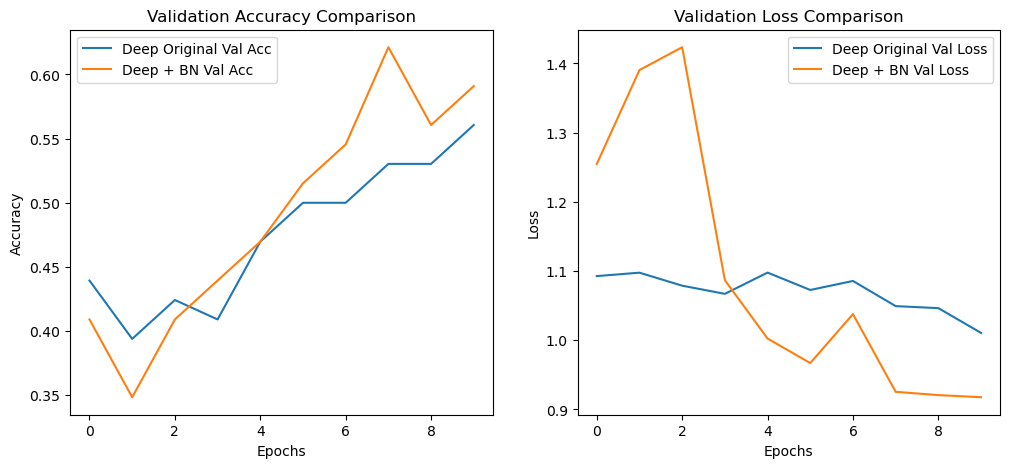

In [24]:
# --- Experiment 3: Deep CNN + Batch Norm ---
print("\nTraining Deep CNN with Batch Norm...")
model_bn = DeepCNN_BN(num_classes=len(class_names)).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

model_bn, hist_bn = train_model(model_bn, criterion, optimizer_bn, num_epochs=10)

# Compare Original Deep vs Deep+BN
plot_comparison(hist_deep, "Deep Original", hist_bn, "Deep + BN")